# Espiral de Parker con Python

En esta entrada veremos la solución numérica a la ecuación diferencial no lineal de primer orden que modela la velocidad del viento solar en función de la distancia heliocéntrica. Una vez se obtiene este perfil de velocidad, el cual es dependiente de la temperatura se procede a transformar a coordenadas lagrangianas centradas en un punto de emisión sobre la corona. De esta forma será más natural construir un brazo de la espiral de Parker, sobre el cual evoluciona el perfil de velocidad hallado.

Cuando hablamos de la "espiral de Parker" nos referimos a la forma del campo magnético del Sol en nuestro sistema solar a raíz de su rotación y la interacción magnetohidrodinámica con el viento solar en expansión. Esto genera una forma de remolino en la descripción del campo magnético y es la que veremos como obtener con Python.

## Viento solar

El [viento solar](https://es.wikipedia.org/wiki/Viento_solar) es un flujo de partículas con carga eléctrica (en su mayoría, electrones $e^-$, protones $p^+$ y partículas alfa $\alpha$), emanadas desde la atmósfera solar. Estas particulas cargadas (gas ionizado o plasma), escapan de la atracción gravitacional del Sol por su alta energía cinética resultado de la temperatura de la corona solar y de la interacción con el campo magnético.  

Las primeras menciones a su existencia corresponden a Biermann en los años 50, quien mediante la observación de la cola de los cometas (en dirección opuesta al sol), sugirió que debía existir un flujo de gas hacia afuera del Sol de forma radial. Parker toma esta observación, y asume el Sol como una masa gravitacional con simetría esférica en expansión estacionaria (con el fin de asegurar la condición de presión cero a distancia infinita) e inicialmente despreciando los efectos del campo magnético. Con estas consideraciones, se logra manifestar la dinámica del flujo de partículas hacia afuera del Sol (Parker, 1958).

## Perfil de velocidad del viento solar  

En el trabajo de Parker bajo condiciones de expansión isotérmica ($\gamma = 1$) de un fluido neutro (primera aproximación al comportamiento del viendo solar), lleva a una ecuación diferencial no lineal de primer orden que relaciona la velocidad del viento solar ($u(r)$) y la distancia heliocéntrica ($r$) ((Parker, 1958), (Kivelson, 1995)).  

\begin{equation}
\frac{du(r)}{dr} = \left(\frac{4kT}{mr} - \frac{GM}{r^2} \right)u(r)\left(u(r)^2 - \frac{2kT}{m} \right)^{-1}
\end{equation}

Con el fin de reducir la propagación de error por los ordenes de magnitud de las variables involucradas, se procede a adimensionalizar la ecuación diferencial, con base al radio y velocidad en el punto crítico (punto sónico) (Piso, 2008).  

\begin{eqnarray}
c_s^2 & = & \frac{2kT}{m}\\
r_c &=& \frac{GM}{2c_s^2}\\
\frac{dv}{dR} &=& \frac{2\left(\frac{1}{R} - \frac{1}{R^2}\right)}{v - \frac{1}{v}}
\end{eqnarray}

Donde $v$ es la velocidad en velocidades sónicas ($c_s$) y $R$ es el radio en radios sónicos ($r_c$). Observamos que alrededor del radio sónico y de la velocidad sónica se presenta un punto crítico que debe satisfacerse para asegurar el sentido físico de la solución. También, tenemos que esta ecuación representa un problema de valores de frontera, y en este caso la condición de frontera del problema en unidades adimensionales es $v(R_{sol}) = v_0$, donde $R_{sol}$ es el radio del Sol, y es la posición desde la cuál comienza a desplazarse el flujo de partículas con una velocidad inicial $v_0$ que dependerá de la densidad de partículas y la temperatura. 
 
La generación de la espiral de Parker es efecto de la rotación del sol, por lo cual se aplica la transformación de coordenadas lagrangianas para sistemas rotantes, llevando a la ecuación diferencial
\begin{equation}
\frac{d\varphi}{dR} = \frac{-\omega}{v(R)}
\end{equation}

## Solución analítica y numérica con Python

Esta ecuación se puede solucionar analíticamente ya que la ecuación permite separación de variables y mediante integración encontrar la solución implícita. Podemos usar [SymPy](https://www.sympy.org/es/), un paquete de álgebra computacional de código abierto y libre, disponible en Python (una alternativa a paquetes comerciales como Maple y Mathematica).  

Respecto a la solución numérica, implementaremos el método de [Runge-Kutta 4 (RK4)](https://es.wikipedia.org/wiki/M%C3%A9todo_de_Runge-Kutta#M%C3%A9todos_de_Runge-Kutta_de_cuarto_orden), y para la solución de la componente angular lo realizaremos de forma simple con el [método de Euler](https://es.wikipedia.org/wiki/M%C3%A9todo_de_Euler) ya que esto evita tener que interpolar la solución de velocidad radial para conocer puntos intermedios requeridos por RK4. Para su implementación vamos a necesitar el manejo de arreglos, y esto los usaremos con [NumPy](https://numpy.org/). Por supuesto, queremos ver gráficos para entender la solución, así que usaremos [Matplotlib](https://matplotlib.org/).  

Así que vamos a instalar, en este caso con la ayuda de UV, el cual es [una alternativa más rápida a _PIP_](project:/es/blog/2024/uv-alternativa-rapida-a-pip-y-venv.md). El `!` es porque es una celda de Notebook, pero si estás en la terminal, puedes omitirla.  

In [1]:
!uv pip install matplotlib numpy sympy

Audited 3 packages in 2ms


Iniciamos con el bloque de importación de los elementos que vamos a necesitar. Cada línea se encuentra comentado con el motivo por el cual lo requerimos para que sea claro su uso.

In [2]:
from math import cos, pi, sin  # Requerido para la transformación polar para ilustrar la solución de la espiral

from IPython.display import display
# Para incluir gráficos en el Notebook en lugar de ventanas emergentes
#%matplotlib inline
import matplotlib.pyplot as plt  # Graficador para los arreglos numéricos
from numpy import array, ones  # Arreglos numéricos y el arreglo de unos
from sympy import (
    dsolve,  # Solucionador de ecuaciones diferenciales ordinarias
    Eq,  # Permite plantear igualdades/ecuaciones
    Function,  # Declara variables que representan funciones
    init_printing,  # Inicializa la opción de visualización de ecuaciones
    plot_implicit,  # Permite los gráficos de funciones implícitas
    solve,  # Solución de ecuaciones algebraicas
    symbols  # Declara símbolos generales
)
init_printing()  # Inicializa sesión de impresión en el Notebook

### Solución analítica

El primer paso es la declaración de los símbolos requeridos. Esto es la función del perfil de velocidad y el símbolo para la distancia al centro del sol. Las funciones se declaran con `Function` y las variables adicionales con `symbols`. En ambos casos, tenemos que el argumento es un _string_ de la letra que representa, y por convención lo asignamos a una variable Python con la misma letra.  

Adicional, vamos a plantear la ecuación que previamente obtuvimos para la forma adimensional, y debemos tener en cuenta que al ser la velocidad una función, se escribe como habitualmente se dispone, indicando su forma con paréntesis y la variable de la cual depende, $v(R)$. Y para expresar la forma de la derivada, las expresiones de SymPy suportan el método `.diff` cuyo argumento es la variable respecto a la cual se deriva. En este caso, se plantearía como `v(R).diff(R)`.

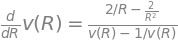

In [13]:
v = Function('v')  # Declara la función de velocidad
R = symbols('R')  # Declara la variable de distancia
# Se plantea la ecuación diferencial
eq_ord = Eq(v(R).diff(R), 2*(1/R - 1/R**2)/(v(R) - 1/v(R)))
eq_ord

SymPy en los métodos soportados, dispone de la opción de separación de variables. Si necesitamos una forma particular o porque queremos dar un indicio al algoritmo, podemos añadir la opción que recomienda el método, en este caso sería `hint='separable'`. Para nuestro caso, es importante indicar el método para que luego la opción de no simplificación nos muestre la ecuación típica que se describe en el artículo de Parker. La función para la solución de ecuaciones diferenciales ordinarias, es `dsolve`.

In [14]:
# Se aplica método de separación de variables
# No se simplifica para mostrar la forma implícita
sol_impl = dsolve(eq_ord, hint='separable', simplify=False)
sol_impl

Solo para los curiosos, también podemos permitir que la solución sea simplificada y obtener la forma explícita, la cual depende de la [función Lambert W](https://es.wikipedia.org/wiki/Funci%C3%B3n_W_de_Lambert). Esta no es la forma usual en la cual encontraremos referenciada la solución, pero gracias a los sistemas de álgebra computacional podemos disponer de esta desde la década de los 90. Para ello podemos quitar la opción de no simplificar, pero también si removemos la recomendación de método, también la vamos a obtener.

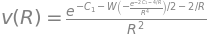

In [15]:
dsolve(eq_ord)

Ahora, para saber que valores de la constante de integración usar, debemos tener presente que la solución debe satisfacer pasar por el punto crítico, y por ende si asignamos el punto crítico, podemos despejar la constante. Para hacer la substitución usamos el método `.subs` que recibe un diccionario donde las llaves son los símbolos originales y los valores son los nuevos valores o símbolos.

In [16]:
solve(sol_impl.subs({v(R): 1, R: 1}))

Para poder graficar, debemos reemplazar la función de velocidad de la función implícita por un símbolo, y proceder con los cambios de la constante de integración para generar la familia de soluciones. Como ya sabemos que para pasar por el punto crítico la constante debe ser $-3/2$, vamos a usar este valor, pero también necesitamos un valor superior (ejemplo, $1$), y un valor inferior (ejemplo, $2$). Para graficar al ser una función implícita, usaremos `plot_implicit` de SymPy que hace un mallado de puntos en el plano de interes para evaluar por celda el cumplimiento de la igualdad. Usaremos `show=False` para que no se muestre cada curva por separado y poder añadir los 3 escenarios en un mismo gráfico.

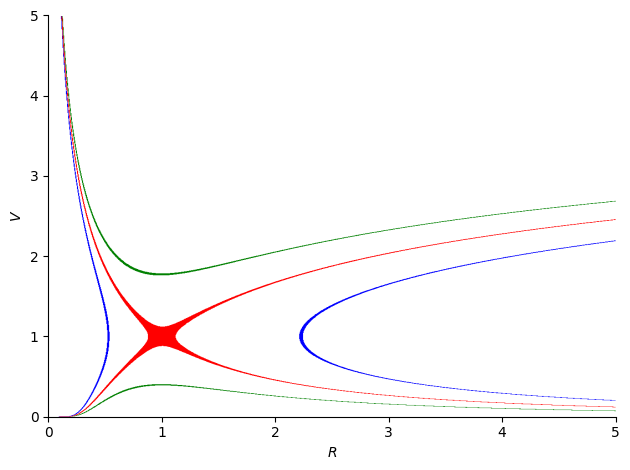

In [7]:
V = symbols('V')  # Símbolo para la velocidad
# Graficamos implícitamente para 3 valores de la constante de integración
# show=False es para no mostrar de una vez, y poder controlar el gráfico unido
# extendiendo y mostrando a discreción
p1 = plot_implicit(
    sol_impl.subs({'C1': -1, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='green',
    show=False
)
p2 = plot_implicit(
    sol_impl.subs({'C1': -2, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='blue',
    show=False
)
p3 = plot_implicit(
    sol_impl.subs({'C1': -1.5, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='red',
    show=False
)
p1.extend([p2[0], p3[0]])  # Anexamos las curvas a la misma figura
p1.show()  # Se muestra la figura

Las curvas azules son referenciadas como las soluciones I y II. Son soluciones de doble evaluación y por ende no son soluciones aceptables físicamente. La curva azul de la derecha (II) además no comienza en la superficie del sol. La curva azul izquierda (I) no hace sentido además porque escaparía del Sol con velocidad subsónica y se devolvería con velocidad supersónica. Las curvas verdes (III - superior, IV - inferior) son soluciones que no pasan por el punto crítico y por ende no son aceptables físicamente. Adicional la curva III inicia con velocidad supersónica en las proximidades del Sol y eso no se ha observado, y la curva IV lleva a una presión constante en el ambiente interestelar, por lo cual no tiene sentido físico. Por el contrario, la curva roja ascendente (V), lleva a un aumento a velocidad supersónica después del punto crítico, lo cual es observado, pero además, lleva a una presión cero en el ambiente interestelar. Esta es conocida como la solución del viento solar.  

:::{attention}

A nivel del gráfico se observa una zona densa alrededor del punto crítico, pero esto es efecto del método de graficación implícito en modo adaptativo
:::

### Solución numérica

Se observa que en el punto crítico $(r_c, c_s)$, se presenta una indeterminación. Por este motivo, es necesario solucionar la ecuación diferencial antes y despues de este punto como dos tramos independientes. El tramo anterior, para asegurar su paso por el punto, lo recomendable es solucionarlo con una forma reversa (_backward_), de tal forma que se pueda usar esta información como condición inicial en la ecuación diferencial en lugar de hacer una estimación de las condiciones iniciales sobre el radio solar (y sería la misma en los dos tramos).  
Siendo así, tenemos que, $v(1) = 1$, para el primer tramo que va desde el radio de la corona solar hasta el punto crítico, y el segundo tramo que va desde el punto crítico hasta la Tierra (por tener un punto de referencia para la solución hacia adelante).  

Planteamos la función para los valores numéricos del lado derecho de la ecuación diferencial ($\frac{d}{dR}v(R)$) en `f_ode` y planteamos nuestra función para el método RK4, `RK4`.  

In [8]:
def f_ode(R, v):
    # Función de la derivada del perfil de velocidad respecto a la distancia
    return 2 * (1/R- 1/R**2)/(v-1/v)

def RK4(funcion, cond_inicial, x_final, n):
    # Implementación del solucionador de Runge Kutta orden 4
    x = [cond_inicial[0]]
    w = [cond_inicial[1]]
    dx = (x_final - x[0]) / n # paso
    dx_2 = dx / 2 # medio paso
    for i in range(n-1):
        k1 = dx * funcion(x[i], w[i])
        k2 = dx * funcion(x[i] + dx_2, w[i] + k1/2)
        k3 = dx * funcion(x[i] + dx_2, w[i] + k2/2)
        x.append(x[i] + dx) # x[i+1] = x[-1]
        k4 = dx * funcion(x[-1], w[i] + k3)
        w.append(w[i] + (k1 + 2*k2 + 2*k3 + k4)/6)
    return x, w

Se definen las constantes requeridas y las funciones para calcular los radios y velocidades sonicas.  

In [9]:
G = 6.67e-11 #Nm2kg-2
k = 1.38065e-23 #JK-1
M = 1.988435e30 #kg, masa del sol
m_H = 1.67372e-27 #kg, masa hidrogeno
r_max = 150e9 #m, dist tierra-sol
r_min = 695.5e6 #m, radio solar
omega_sol = 2.7e-6 #rads-1, vel angular sol
T_cor = 1e6 #K, temp corona solar

def c_s(T = T_cor, m = m_H):
    # Velocidad sónica, la cual depende de la temperatura y densidad del medio
    from math import sqrt
    return sqrt(2*k*T/m)

def r_c(T = T_cor, m = m_H):
    # Radio sónico
    return G*M / (2 * c_s(T, m)**2)

Se determinan los parámetros en unidades adimensionales.  

In [10]:
vel_s = c_s(T_cor, m_H)
rad_s = r_c(T_cor, m_H)
t_s = rad_s / vel_s
print("Velocidad sónica: {:f}km/s".format(vel_s/1000))
print("Radio sónico: {:f}km".format(rad_s/1000))
print("Unidad de tiempo: {:f}s".format(t_s))
omega_s = omega_sol * t_s
print("omega (adim): {:f}".format(omega_s))
R_max = r_max / rad_s
R_min = r_min / rad_s
print("Radio máximo (adim): {:f}".format(R_max))
print("Radio mínimo (adim): {:f}".format(R_min))

Velocidad sónica: 128.444465km/s
Radio sónico: 4019540.880399km
Unidad de tiempo: 31293.998427s
omega (adim): 0.084494
Radio máximo (adim): 37.317695
Radio mínimo (adim): 0.173030


Ahora aplicamos el método RK4 para los tramos y gráficamos. Es necesario tener presente que al estar reverso el primer tramo, también para disponer la solución hay que aplicar el reverso de la lista (`.reverse`) y así tener la solución ordenada.  

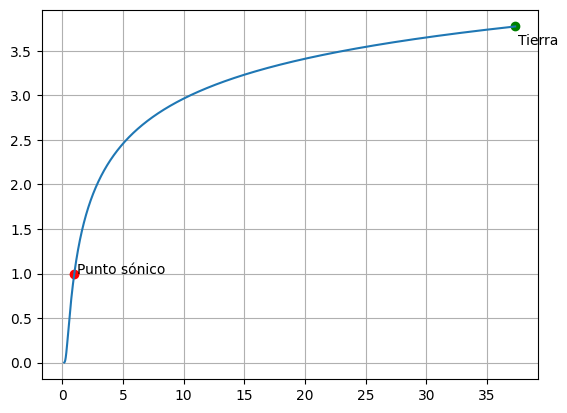

In [11]:
# Solución numérica de la ecuación de viento solar
R, v = RK4(f_ode, [1, 1-1e-6], R_min, 30000)
R.reverse()
v.reverse()
R_sup, v_sup = RK4(f_ode, [1, 1+ 1e-6 ], R_max, 1000000)
v.extend(v_sup)
R.extend(R_sup)
# Graficamos
plt.plot(1, 1, 'or')
plt.text(1.2, 1, 'Punto sónico')
plt.plot(R[-1], v[-1], 'og')
plt.text(R[-1] + .2, v[-1]-.2,'Tierra')
plt.plot(R, v)
plt.grid()
plt.show()

Partiendo de este perfil de velocidad se contruye la componente angular de la velocidad para generar finalmente la conocida espiral de Parker, y lo podemos hacer con el método de Euler.  

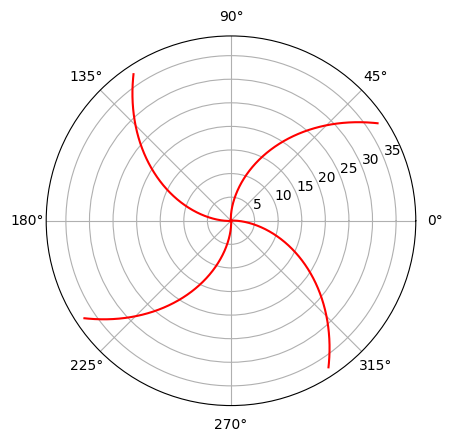

In [12]:
N = len(R)
cont = 0
psi = [0]
x = [R[0]*cos(psi[0])]
y = [R[0]*sin(psi[0])]
while cont < N-1:
    # Método de Euler
    dR = R[cont + 1] - R[cont]
    dpsi = -omega_s * dR / v[cont]
    psi.append(psi[-1] + dpsi)
    cont = cont + 1

dpsi_v = ones([N]) * pi / 2
psi1 = array(psi)
psi2 = psi1 + dpsi_v
psi3 = psi2 + dpsi_v
psi4 = psi3 + dpsi_v
espiral = plt.subplot(111, projection='polar')
espiral.plot(psi1, R, color='r')
espiral.plot(psi2, R, color='r')
espiral.plot(psi3, R, color='r')
espiral.plot(psi4, R, color='r')

# Referencias  

- E. N. Parker, ["Dynamics of the Interplanetary Gas and Magnetic Fields"](https://articles.adsabs.harvard.edu/pdf/1958ApJ...128..664P), Astrophysical Journal, 128, 1958 p. 664.  
- Margaret G. Kivelson y Christopher T. Russel, "Introduction to Space Physics", Cambridge University Press, 1995, 588 p.  
- Ana Maria Piso, ["The Solar Wind" from Wolfram Demonstrations Project](http://demonstrations.wolfram.com/TheSolarWind/), Agosto 6 de 2008.  
- Richard L. Burden y J. Douglas Faires, "Análisis Numérico", 7Ed., Ediciones Paraninfo, 2002 p. 839.  